In [1]:
import numpy as np
from scipy.linalg import circulant
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib as mpl 

## Problem 1

Using code from previous homeworks, the additional Euler, RK2, and RK3 is added

In [81]:
# Operator from HW1
def D_operator_periodic(N,L,R,a):
    first_row = np.zeros(N); first_row[0:L+R+1] = a; first_row = np.roll(first_row,-L)
    return np.array(circulant(first_row)).transpose()

# Functor for the 1D advection equation
def LinearAdv1D(t,U,D):
    # Initialize velocity
    a = 1
    # Return F(t,U)
    return (-a*D)@U

def euler(F, t, U, dt, D):
    return U + F(t, U, D) * dt

def rk2(F, t, U, dt, D):
    k1 = F(t, U, D)
    k2 = F(t + dt, U + k1 * dt, D)
    return U + (k1 + k2) / 2 * dt

def rk3(F, t, U, dt, D):
    k1 = F(t, U, D)
    k2 = F(t + dt/2, U + k1 * dt/2, D)
    k3 = F(t + dt, U - k1 * dt + 2 * k2 * dt, D)
    return U + (k1 + 4*k2 + k3) / 6 * dt

# General integrator function
def Integrator(periodic,operator,problem,L,T,Nx,Nt,U0, method):
    # Initialize spatial domain
    x  = np.linspace(0, L, Nx, endpoint=(not periodic))
    dx = x[1] - x[0]

    # Initialize temporal domain
    t  = np.linspace(0, T, Nt, endpoint=True)
    dt = T / (Nt - 1)

    # Construct spatial matrix operator
    match (operator,periodic):
        case ('1st-order upwind',True):       # Periodic 1st-order upwind
            D = D_operator_periodic(Nx,1,0,[-1/dx,1/dx])
        case ('2nd-order central',True):      # Periodic 2nd-order central differences
            D = D_operator_periodic(Nx,1,1,[-1/(2*dx),0,1/(2*dx)])
        case ('3rd-order upwind',True):       # Periodic 3rd-order upwind
            D = D_operator_periodic(Nx,2,1,[1/(6*dx),-1/dx,1/(2*dx),1/(3*dx)])
        case ('4th-order central',True):      # Periodic 4th-order central differences
            D = D_operator_periodic(Nx,2,2,[1/(12*dx),-8/(12*dx),0,8/(12*dx),-1/(12*dx)])
        case ('6th-order Padé',True):         # Periodic 6th-order Padé
            DR = D_operator_periodic(Nx,2,2,[-1/(36*dx),-28/(36*dx),0,28/(36*dx),1/(36*dx)])
            DL = D_operator_periodic(Nx,1,1,[1/3,1,1/3])
            D = np.linalg.inv(DL)@DR
        case _:
            raise Exception("The %s operator '%s' is not yet implement!" % ('periodic' if periodic else 'non-periodic', operator))

    # Solve and return solutions!
    U = np.zeros((Nt, Nx))
    U[0, :] = U0

    step_method = {
        'Euler': euler,
        'RK2': rk2,
        'RK3': rk3
    }[method]

    for n in range(1, Nt):
        t[n] = t[n-1] + dt
        U[n, :] = step_method(LinearAdv1D, t[n-1], U[n - 1, :], dt, D)

    # Return outputs
    return t, U, D

## Problem 2

When $\mathbf{F}(t, \mathbf{U}(t)) = \mathbf{AU}(t)$

### For Euler:

The update formula for the system is 
$$\mathbf{U}(t + \Delta t) = \mathbf{U}(t) + \Delta t \mathbf{AU}(t)$$
$$\mathbf{U}(t + \Delta t) = (\mathbf{I} + \Delta t \mathbf{A})\mathbf{U}(t)$$

If $\lambda$ is a eigenvalue of $\mathbf{A}$, then the corresponding eigenvalue of the matrix $(\mathbf{I} + \Delta t \mathbf{A})$ is $1 + \Delta t$, so the Euler method is stable when $| 1+ \Delta t \lambda | \leq 1$

### For Runge-Kutta 2 (RK2)

The RK2 method can be written as:
$$ U(t + \Delta t) = U(t) + \frac{\Delta t}{2} (k_1 + k_2) $$
where
$$ k_1 = A U(t) $$
$$ k_2 = A (U(t) + \Delta t k_1) $$

Substitute $k_1$ into $k_2$ and expand:
$$ k_2 = A U(t) + \Delta t A^2 U(t) $$
$$ k_2 = k_1 + \Delta t A k_1 $$

Now the update step in terms of $k_1$ and $k_2$ becomes:
$$ U(t + \Delta t) = U(t) + \Delta t k_1 + \frac{\Delta t^2}{2} A k_1 $$

Substitute $k_1 = A U(t)$:
$$ U(t + \Delta t) = U(t) + \Delta t A U(t) + \frac{\Delta t^2}{2} A^2 U(t) $$
$$ U(t + \Delta t) = (I + \Delta t A + \frac{\Delta t^2}{2} A^2) U(t) $$

The stability condition for RK2 is then:
$$1 + \Delta t \lambda + \frac{(\Delta t \lambda)^2}{2} $$
$$|1 + \Delta t \lambda + \frac{(\Delta t \lambda)^2}{2}| \leq 1 $$

### For Runge-Kutta 3 (RK3)

The RK3 method involves three stages and can be written as:
\begin{align*}
k_1 &= \lambda U(t) \\
k_2 &= \lambda \left( U(t) + \frac{\Delta t}{2} k_1 \right) \\
k_3 &= \lambda \left( U(t) - \Delta t k_1 + 2 \Delta t k_2 \right) \\
U(t + \Delta t) &= U(t) + \frac{\Delta t}{6} (k_1 + 4 k_2 + k_3)
\end{align*}

Substituting the expressions for $k_1$, $k_2$, and $k_3$ into the final update formula and simplifying, we get:
\begin{align*}
U(t + \Delta t) &= U(t) + \frac{\Delta t}{6} \left[ \lambda U(t) + 4 \lambda \left( U(t) + \frac{\Delta t}{2} \lambda U(t) \right) + \lambda \left( U(t) - \Delta t \lambda U(t) + 2 \Delta t \lambda \left( U(t) + \frac{\Delta t}{2} \lambda U(t) \right) \right) \right] \\
&= U(t) + \frac{\Delta t}{6} \left[ \lambda + 2 \Delta t \lambda^2 + \frac{1}{2} \Delta t^2 \lambda^3 \right] U(t) + \frac{\Delta t}{6} \left[ 4 \lambda + 4 \Delta t \lambda^2 \right] U(t) + \frac{\Delta t}{6} \left[ \lambda - \Delta t \lambda^2 + 2 \Delta t^2 \lambda^3 \right] U(t) \\
&= U(t) + \Delta t \lambda U(t) + \frac{\Delta t^2}{2} \lambda^2 U(t) + \frac{\Delta t^3}{6} \lambda^3 U(t) \\
&= \left(1 + \Delta t \lambda + \frac{\Delta t^2}{2} \lambda^2 + \frac{\Delta t^3}{6} \lambda^3 \right) U(t)
\end{align*}

Here, the term in the parentheses is the stability function for the RK3 method. The stability condition is then:
$$| 1 + \Delta t \lambda + \frac{(\Delta t \lambda)^2}{2} + \frac{(\Delta t \lambda)^3}{6}| \leq 1 $$


!!

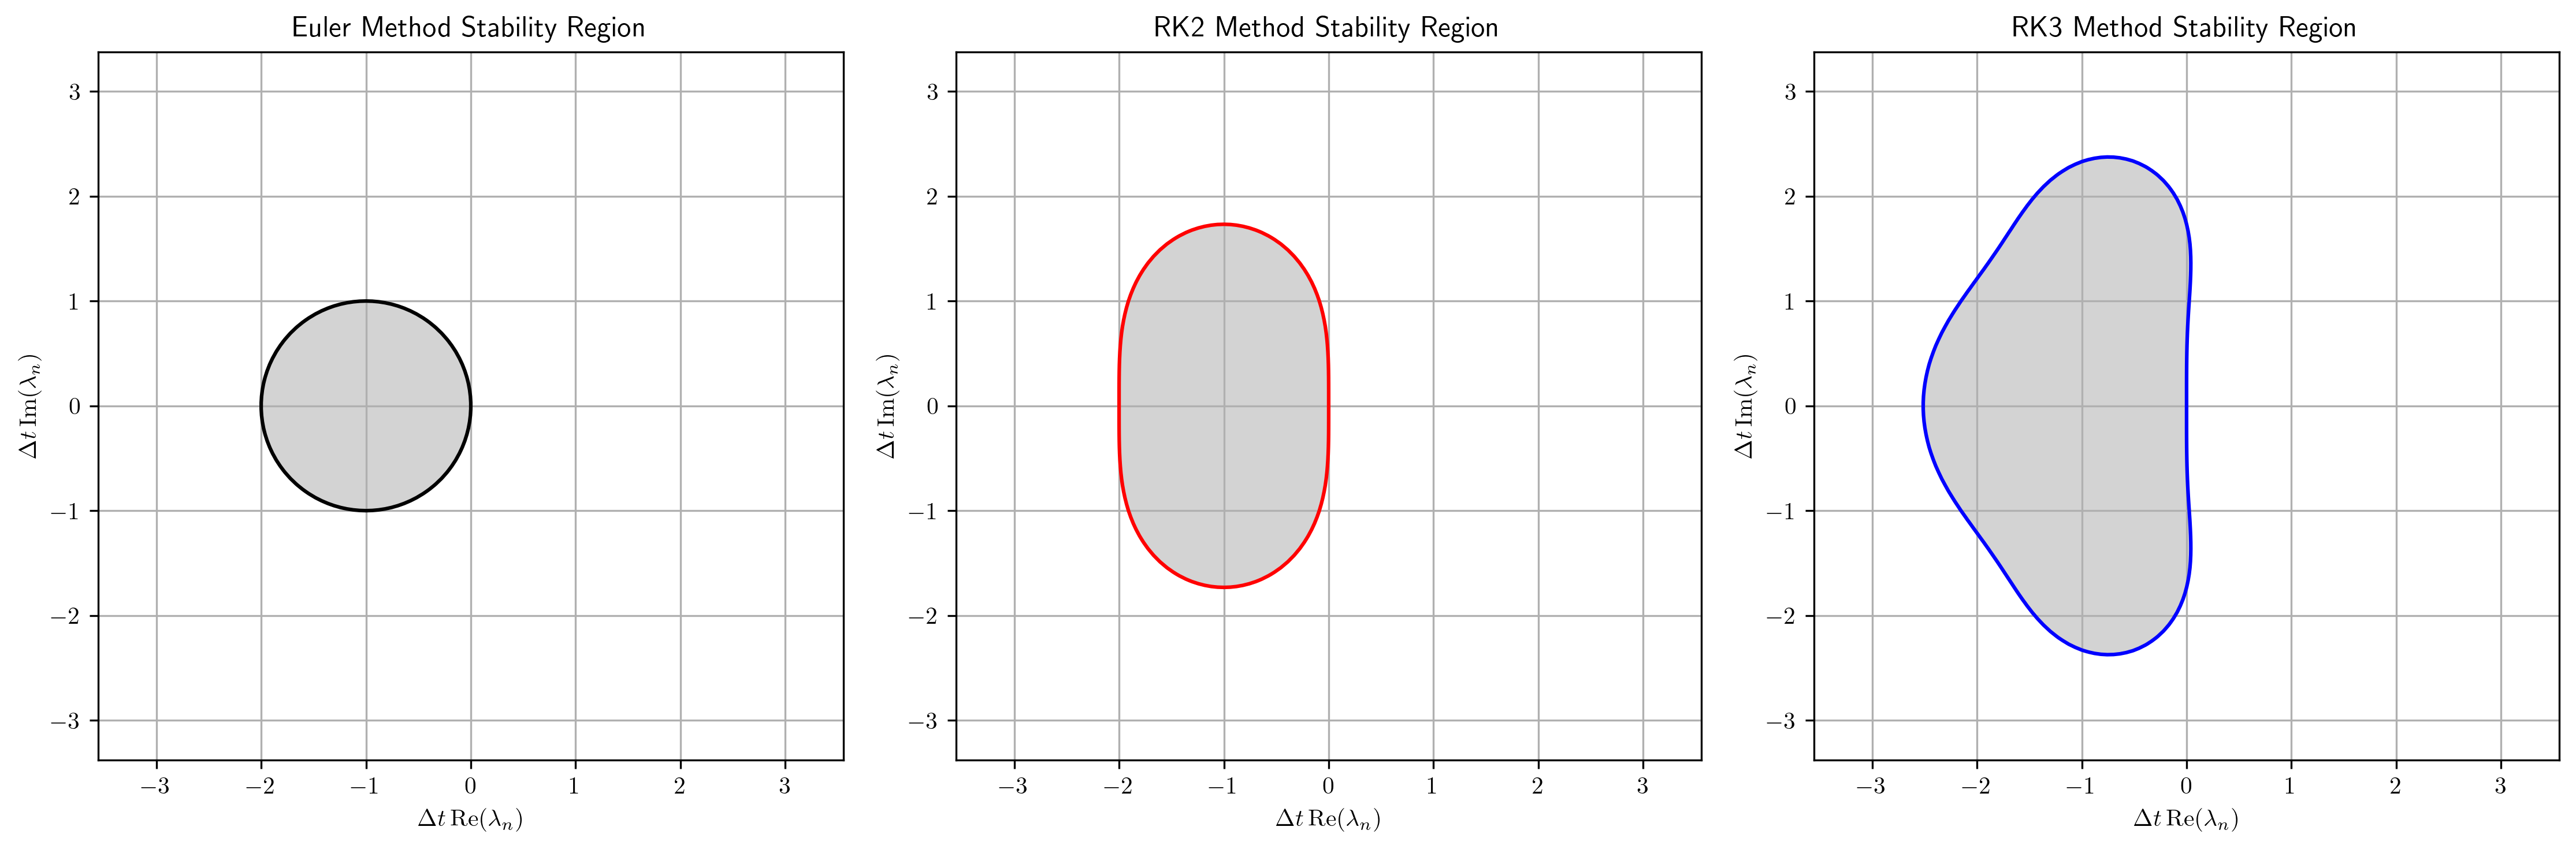

In [104]:
s = np.linspace(-3, 3, 100, endpoint=True)
re, im = np.meshgrid(s, s)
dt_lambda = re + 1j*im
z = dt_lambda

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Euler
axs[0].contour(re, im, np.abs(1 + z), [1], colors='k')
axs[0].contourf(re, im, np.abs(1 + z), [0, 1], colors='lightgrey')
axs[0].set_title('Euler Method Stability Region')
axs[0].set_xlabel(r'$\Delta t\, \mathrm{Re}(\lambda_n)$')
axs[0].set_ylabel(r'$\Delta t\, \mathrm{Im}(\lambda_n)$')
axs[0].grid(True)
axs[0].axis('equal')

# RK2
axs[1].contour(re, im, np.abs(1 + z + z**2 / 2), [1], colors='r')
axs[1].contourf(re, im, np.abs(1 + z + z**2 / 2), [0, 1], colors='lightgrey')
axs[1].set_title('RK2 Method Stability Region')
axs[1].set_xlabel(r'$\Delta t\, \mathrm{Re}(\lambda_n)$')
axs[1].set_ylabel(r'$\Delta t\, \mathrm{Im}(\lambda_n)$')
axs[1].grid(True)
axs[1].axis('equal')

# RK3
axs[2].contour(re, im, np.abs(1 + z + z**2 / 2 + z**3 / 6), [1], colors='b')
axs[2].contourf(re, im, np.abs(1 + z + z**2 / 2 + z**3 / 6), [0, 1], colors='lightgrey')
axs[2].set_title('RK3 Method Stability Region')
axs[2].set_xlabel(r'$\Delta t\, \mathrm{Re}(\lambda_n)$')
axs[2].set_ylabel(r'$\Delta t\, \mathrm{Im}(\lambda_n)$')
axs[2].grid(True)
axs[2].axis('equal')

plt.tight_layout()
plt.show()

## Problem 3

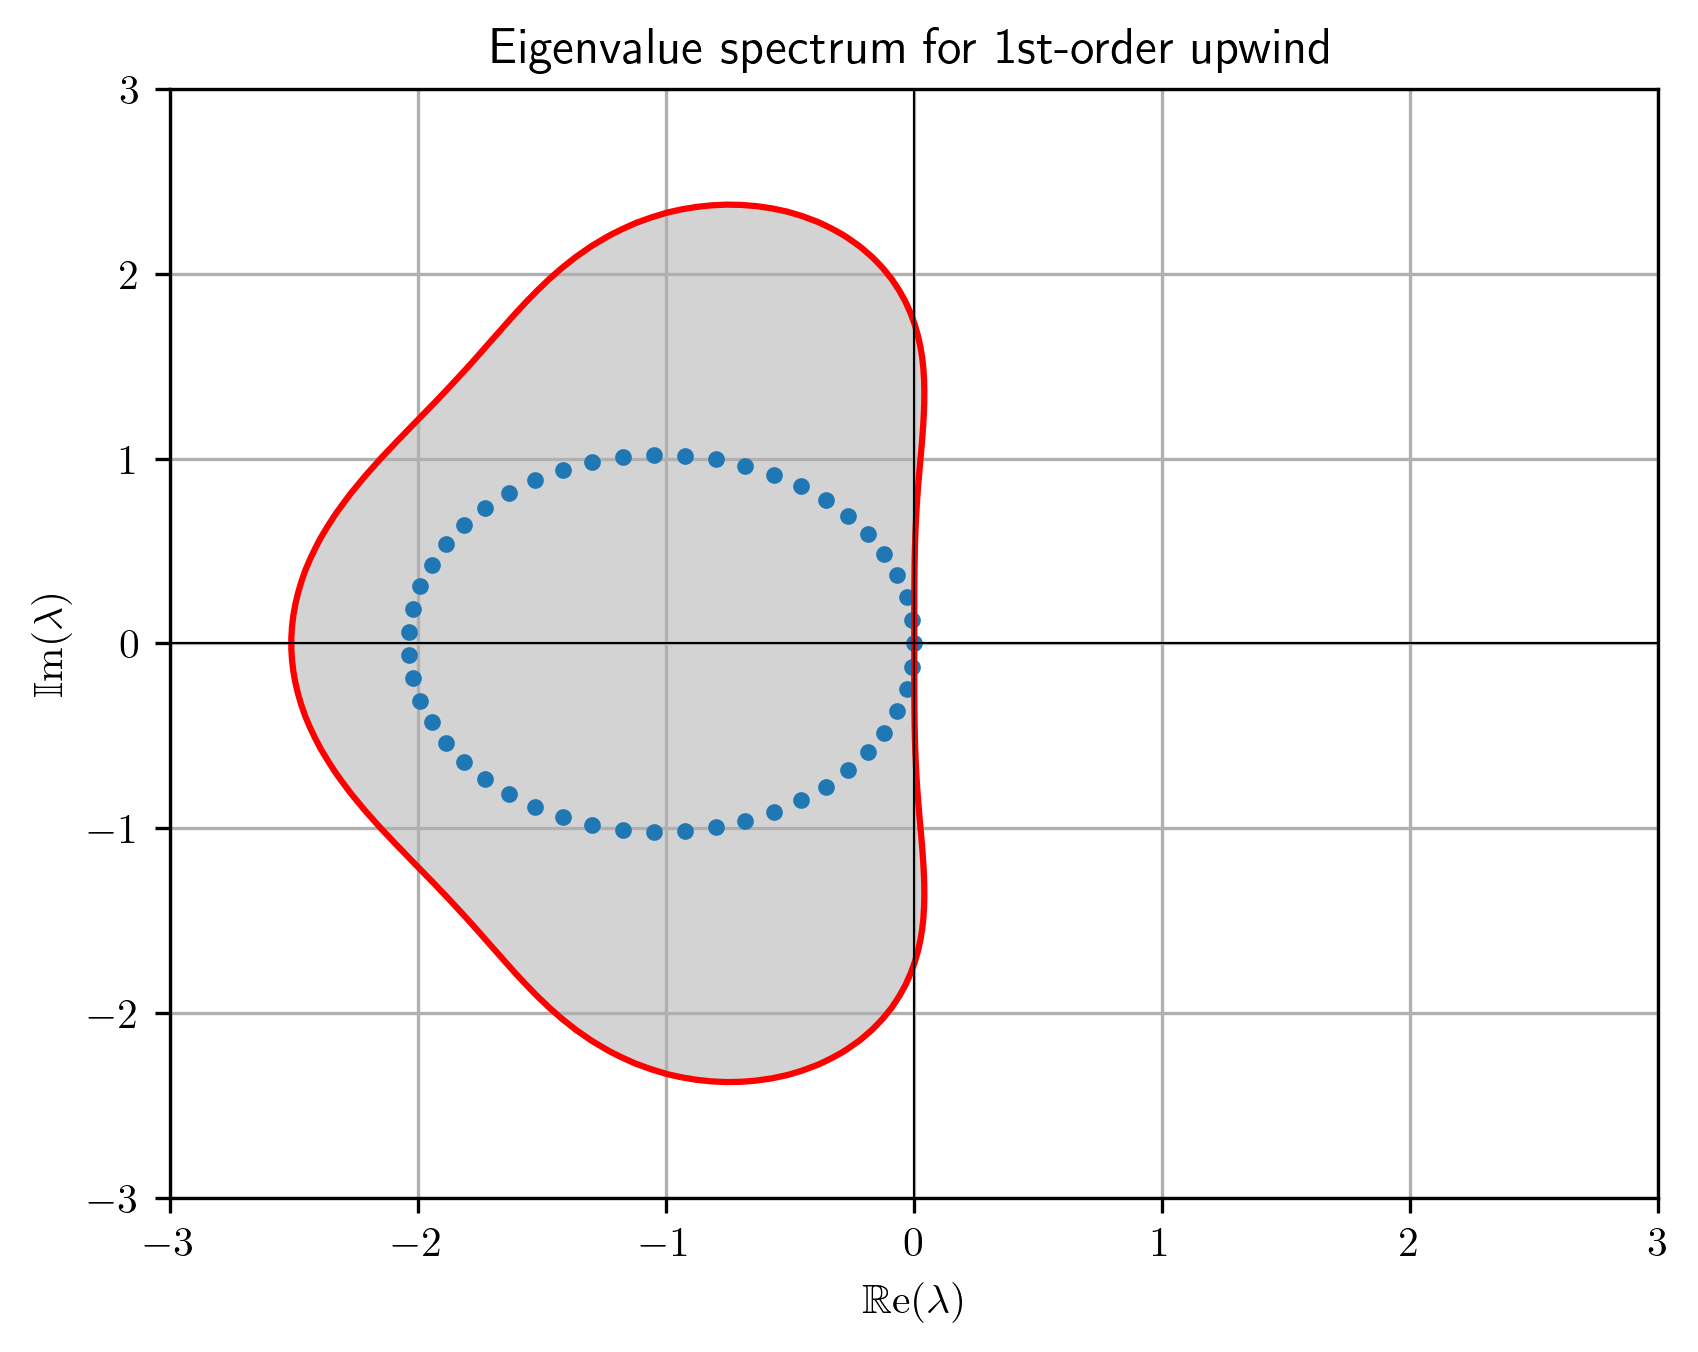

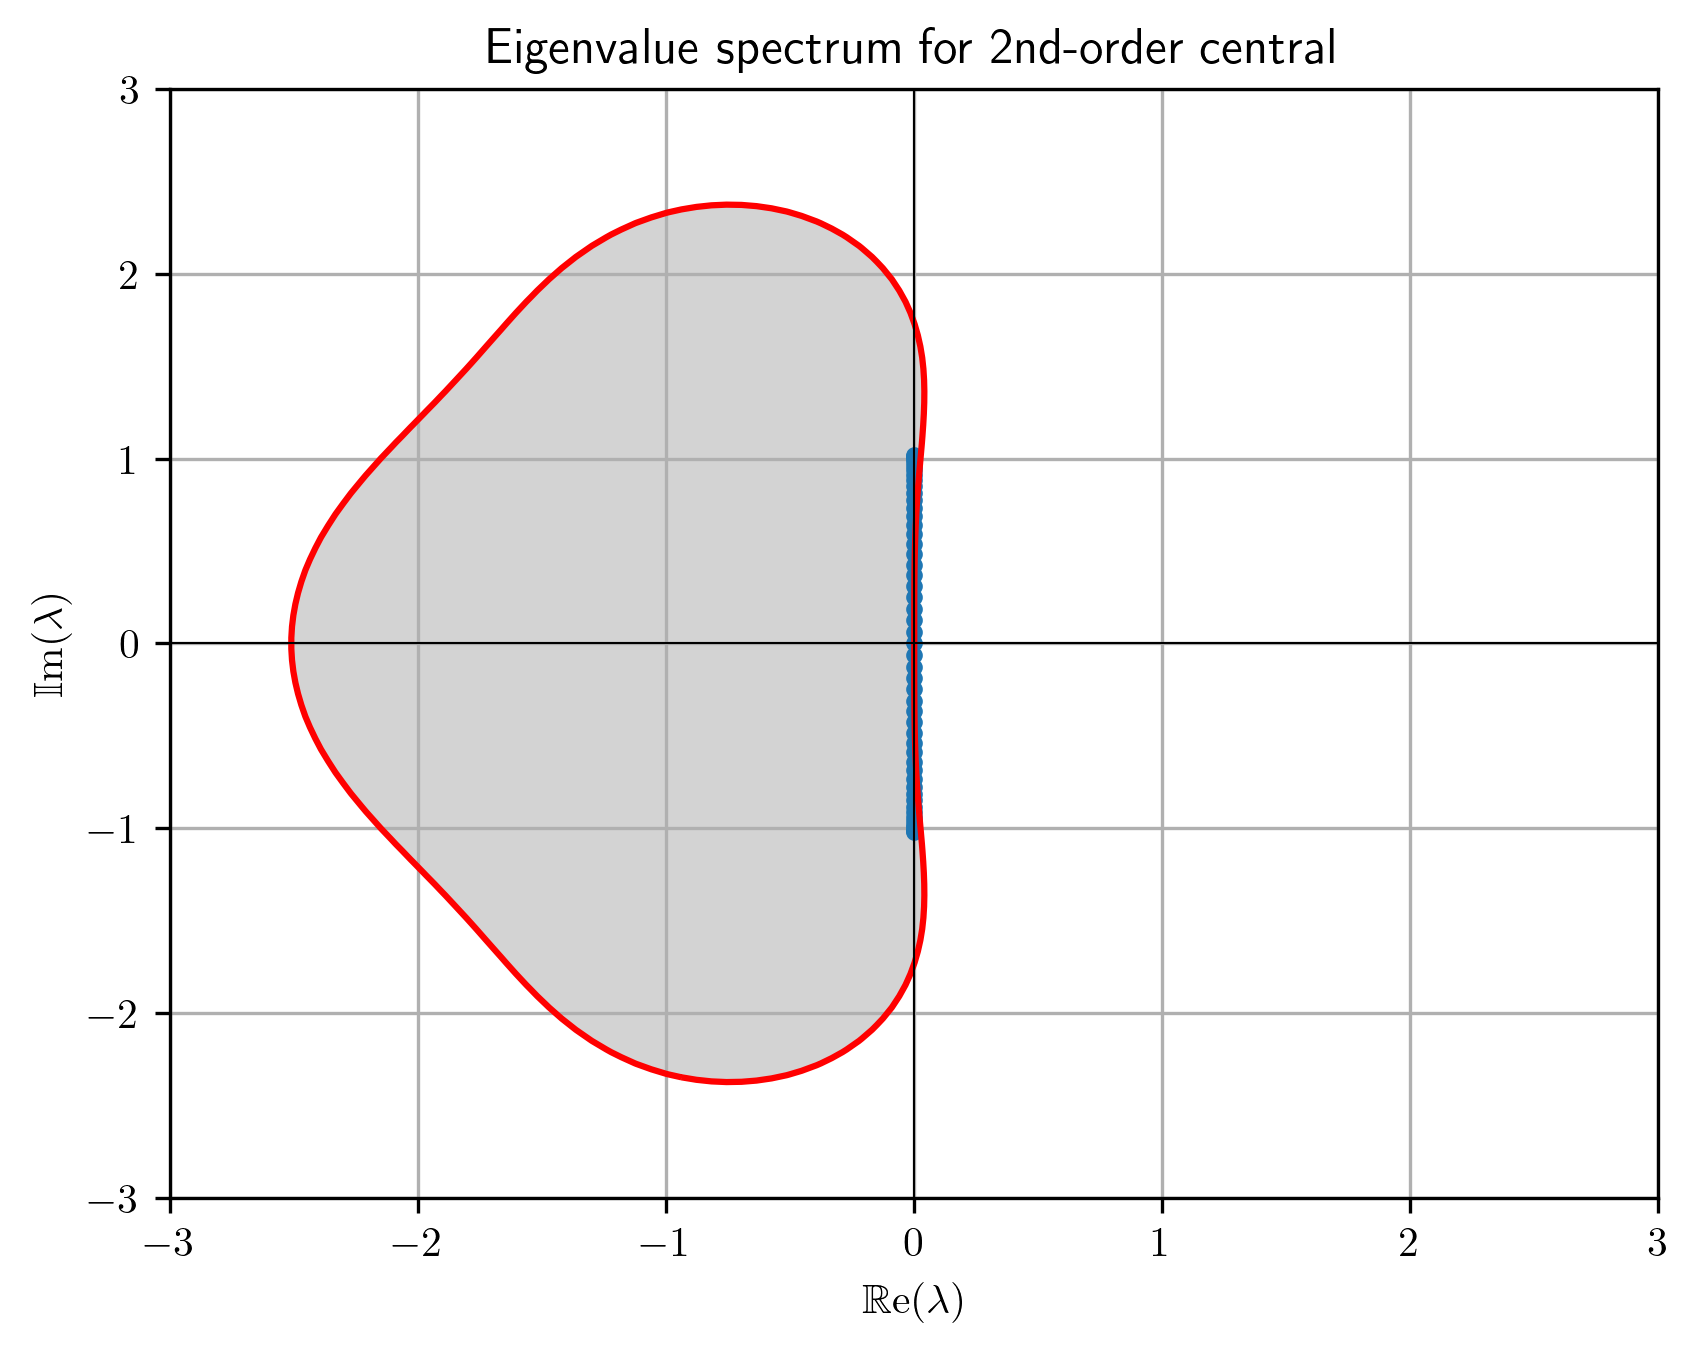

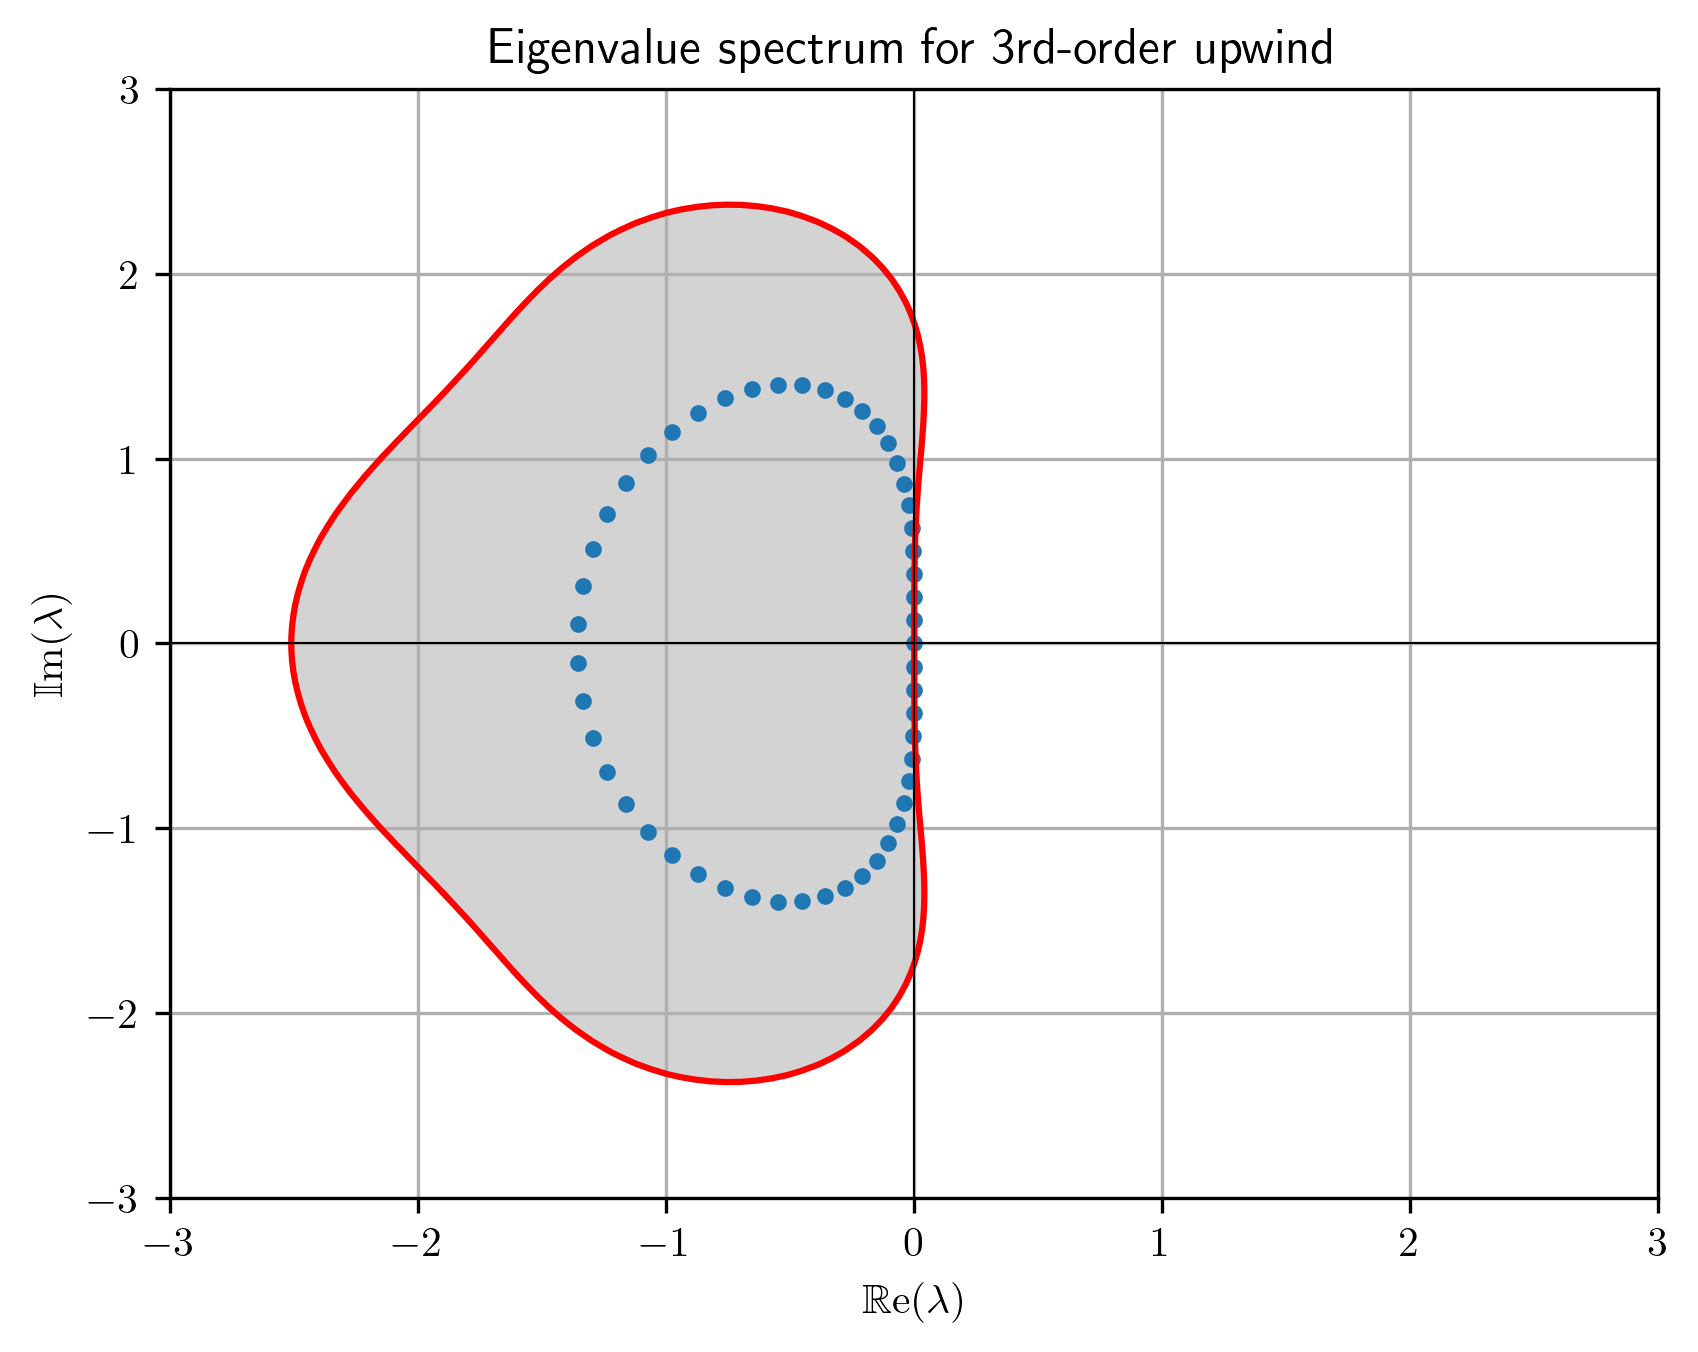

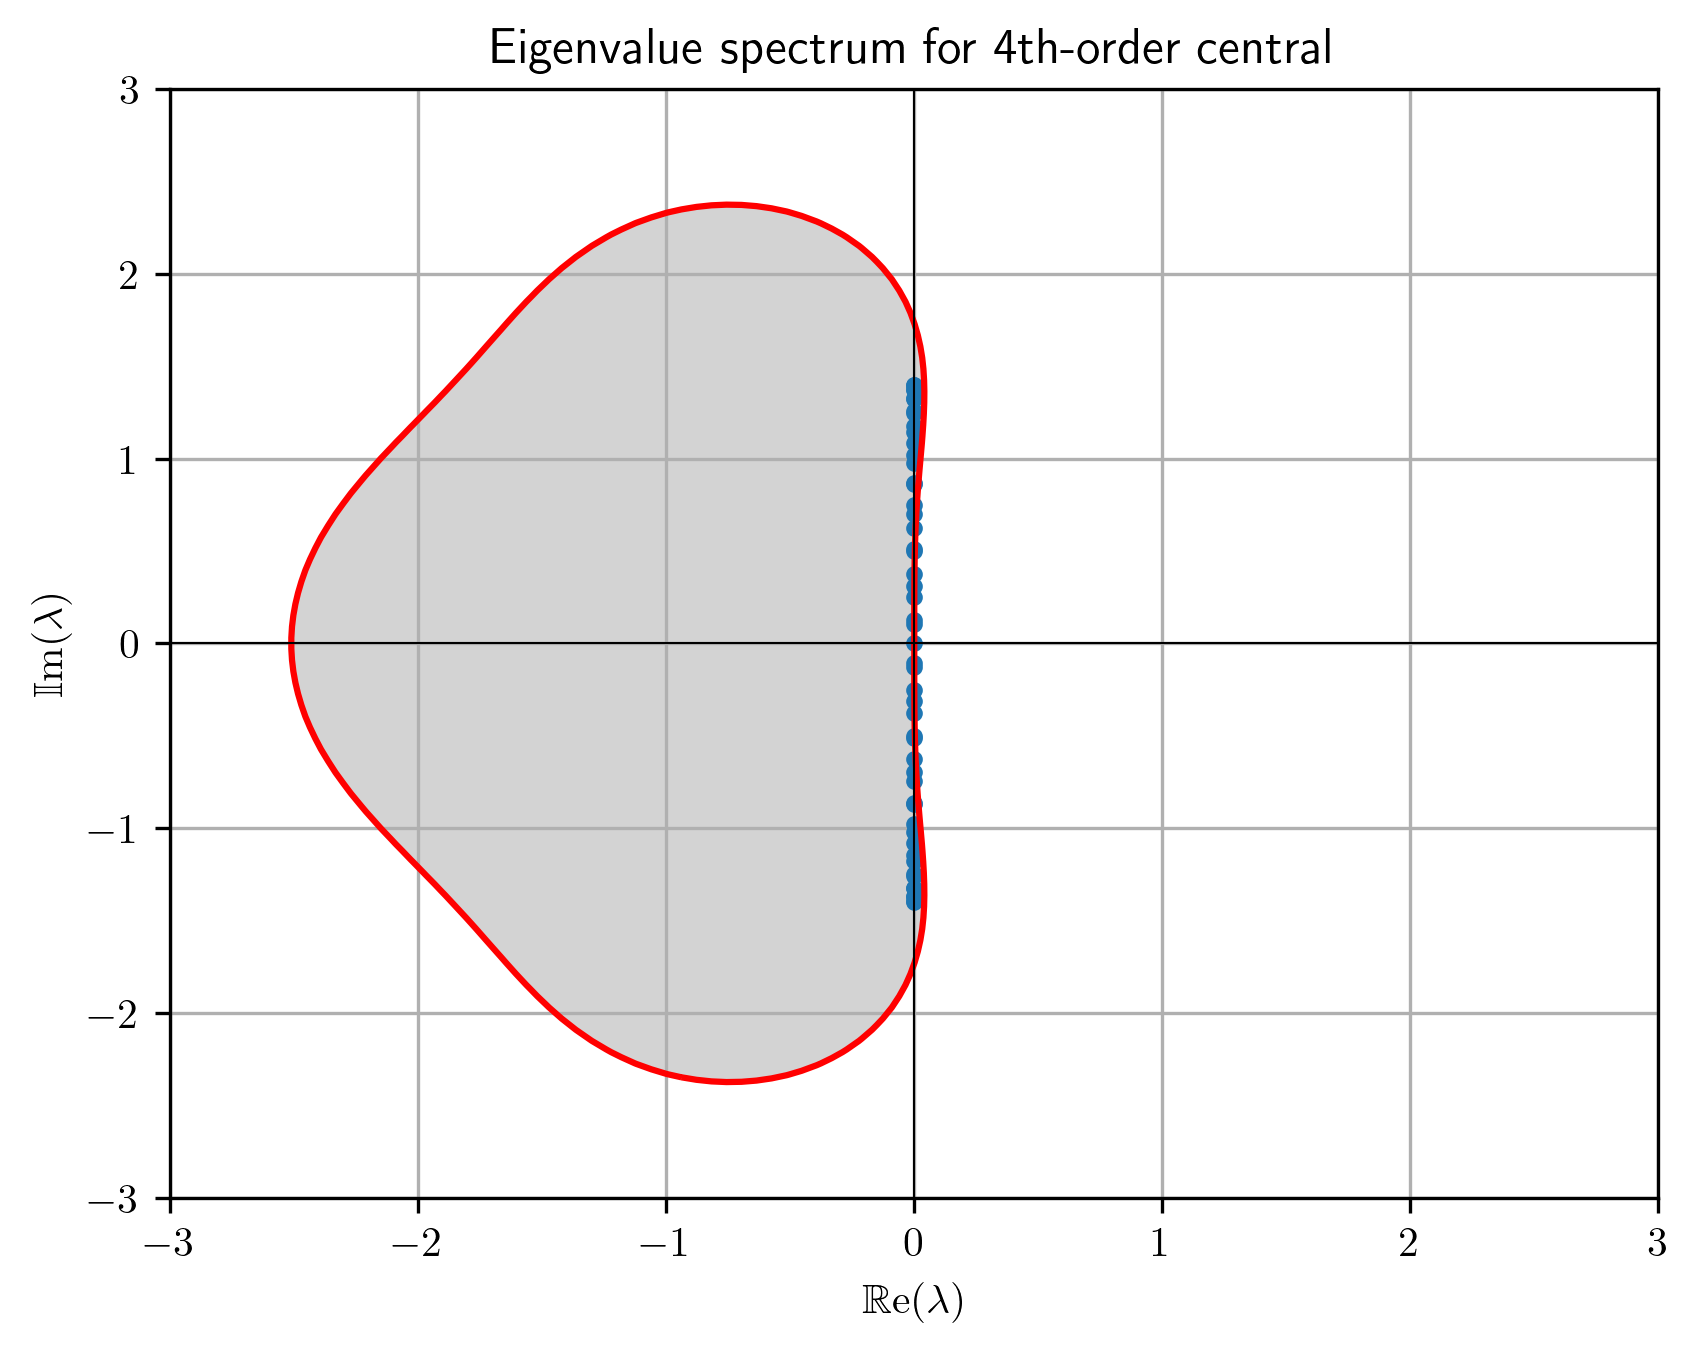

In [130]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
from numpy import linalg as LA
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

# Initialize case parameters
L = 1; T = 30; Nx = 51; a = 1; CFL = 1
# Initialize solution at t=0
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]
dt = CFL * dx / np.abs(a)
var_t = np.arange(0, T, dt)
Nt = len(var_t)
sigma = 3/40; U0 = np.exp(-(x-0.5)**2/(2*sigma**2))
# Initialize list of schemes that will be tested:
listofschemes = ['1st-order upwind', '2nd-order central', '3rd-order upwind', '4th-order central']


for scheme in listofschemes:
    fig, ax = plt.subplots(1, 1)
    t, U, D = Integrator(True, scheme, 'LinearAdv1D',L, T, Nx, Nt, U0, 'RK3')
    A.append(-a*D)
    eigenvalues, eigenvectors = LA.eig(-a*D) 
    plt.plot(np.real(eigenvalues) * dt, np.imag(eigenvalues) * dt, '.')
    s = np.linspace(-3, 3, 100, endpoint=True)
    re, im = np.meshgrid(s, s)
    z = re + 1j*im
    plt.contour(re, im, np.abs(1 + z + z**2 / 2 + z**3 / 6), [1], colors='red')
    plt.contourf(re, im, np.abs(1 + z + z**2 / 2 + z**3 / 6), [0, 1], colors='lightgrey')
    plt.title('Eigenvalue spectrum for %s' % scheme)
    plt.xlabel(r'$\mathbb{R}\mathrm{e}(\lambda)$');plt.ylabel(r'$\mathbb{I}\mathrm{m}(\lambda)$');
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)
    plt.show()

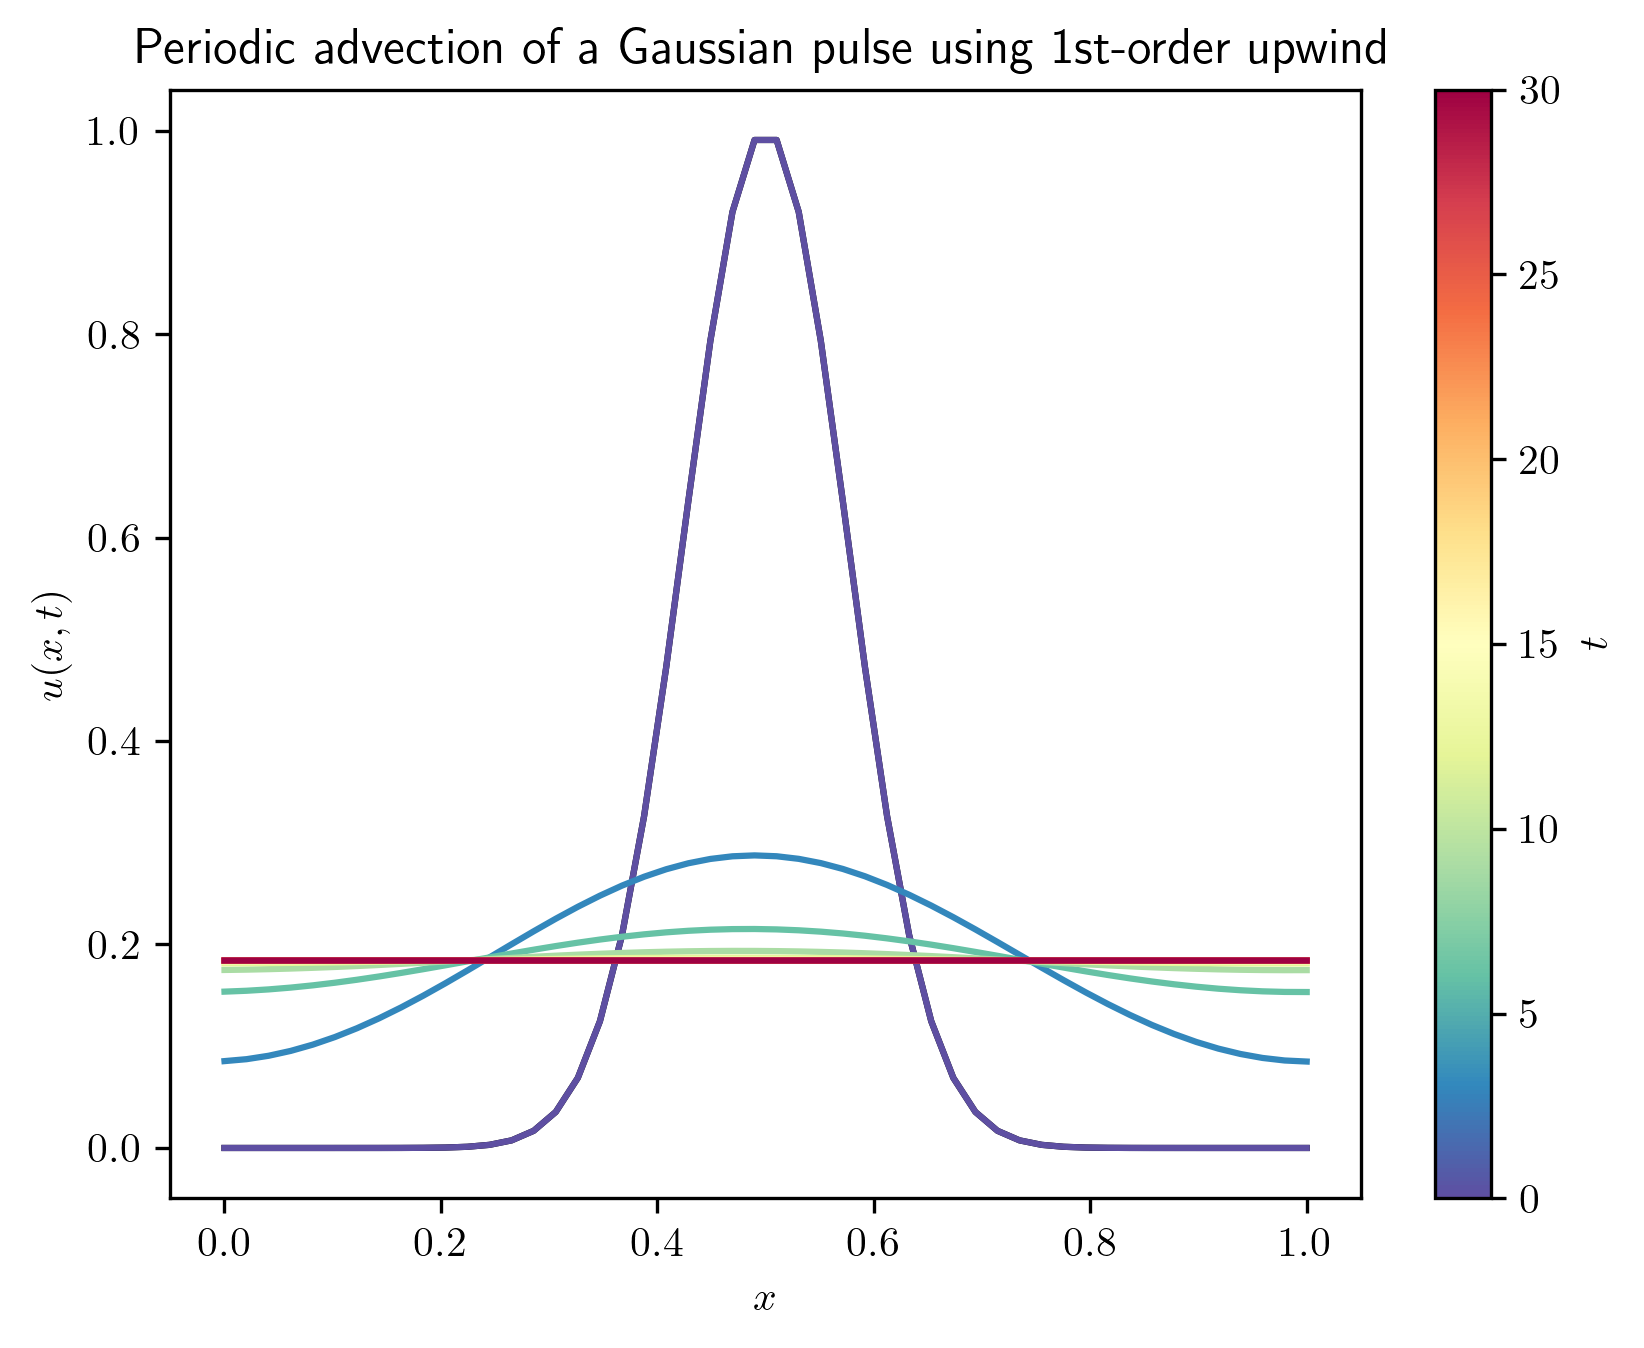

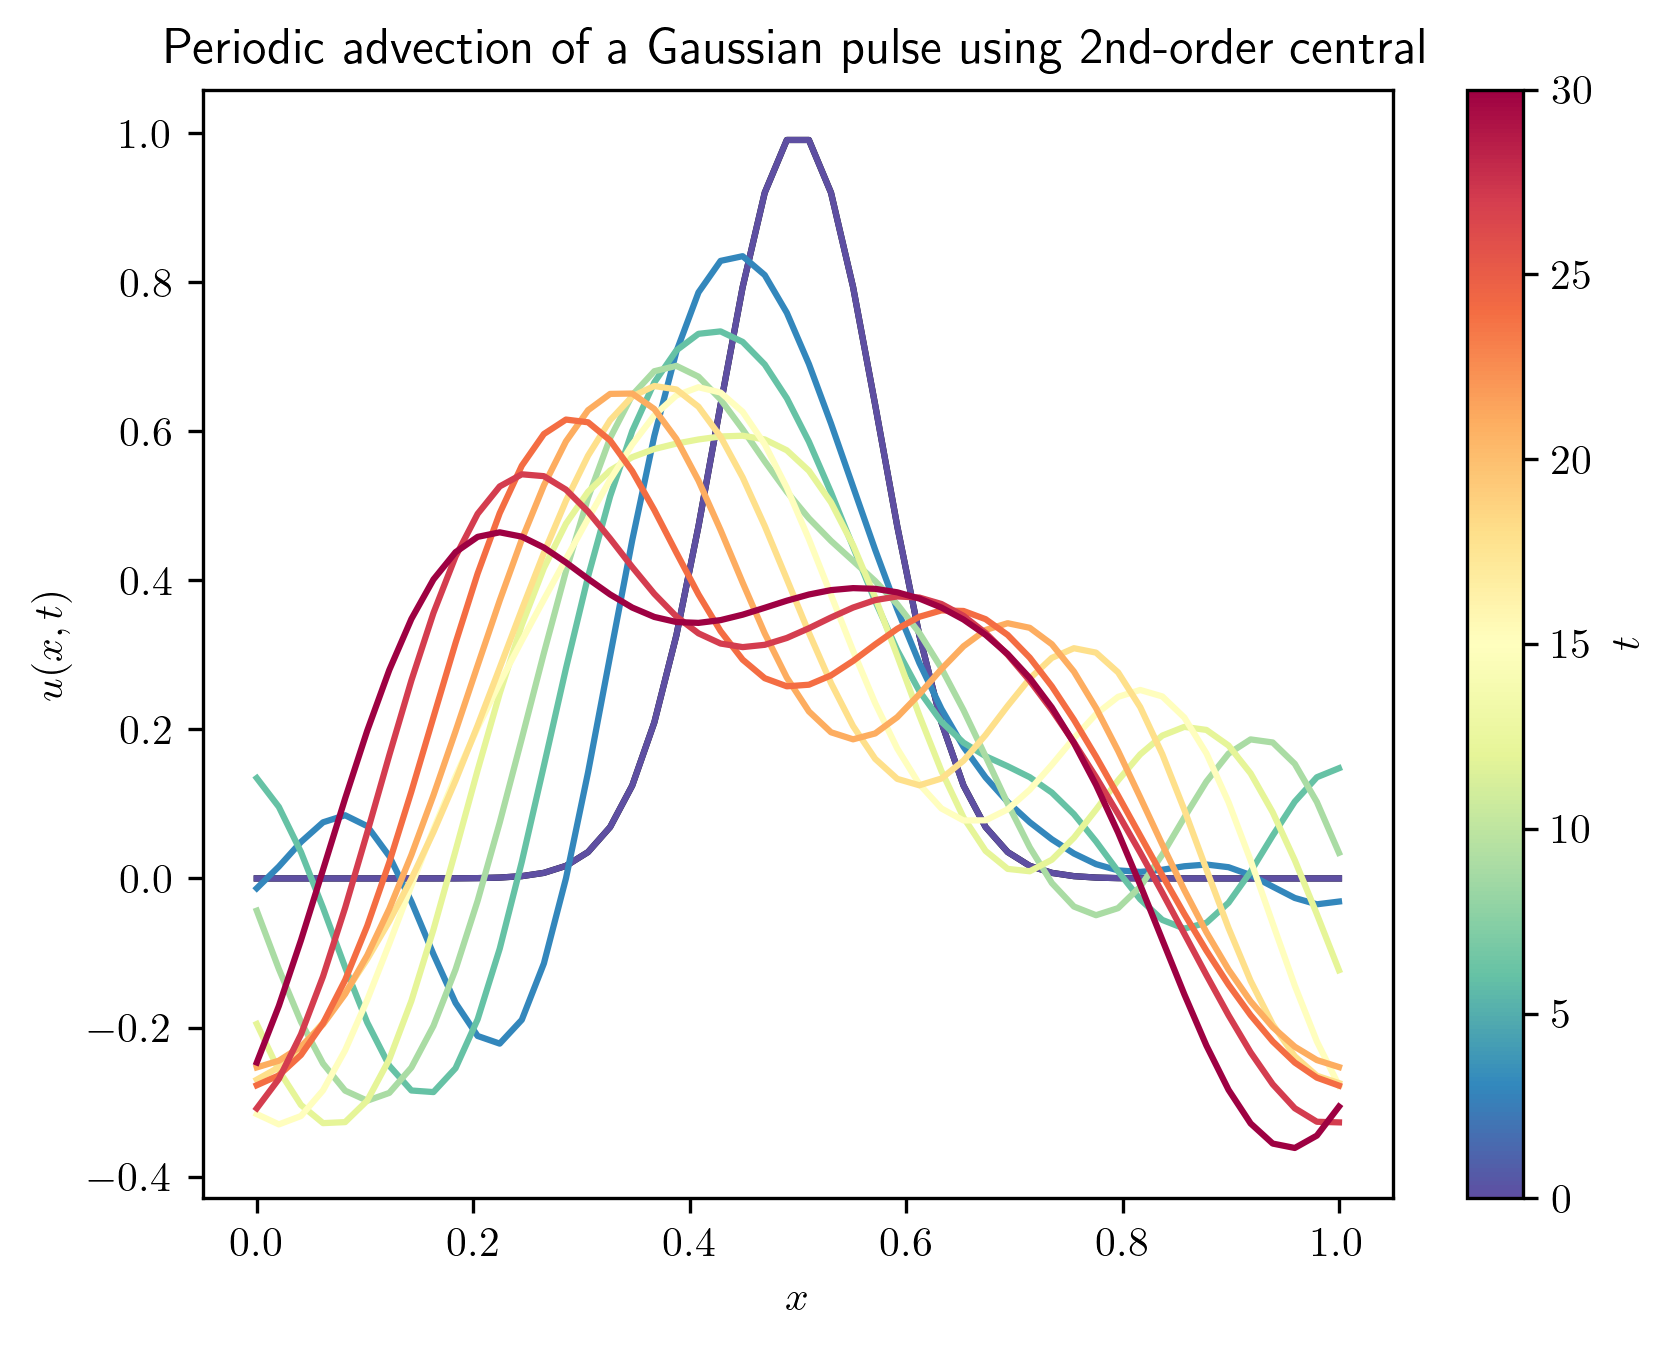

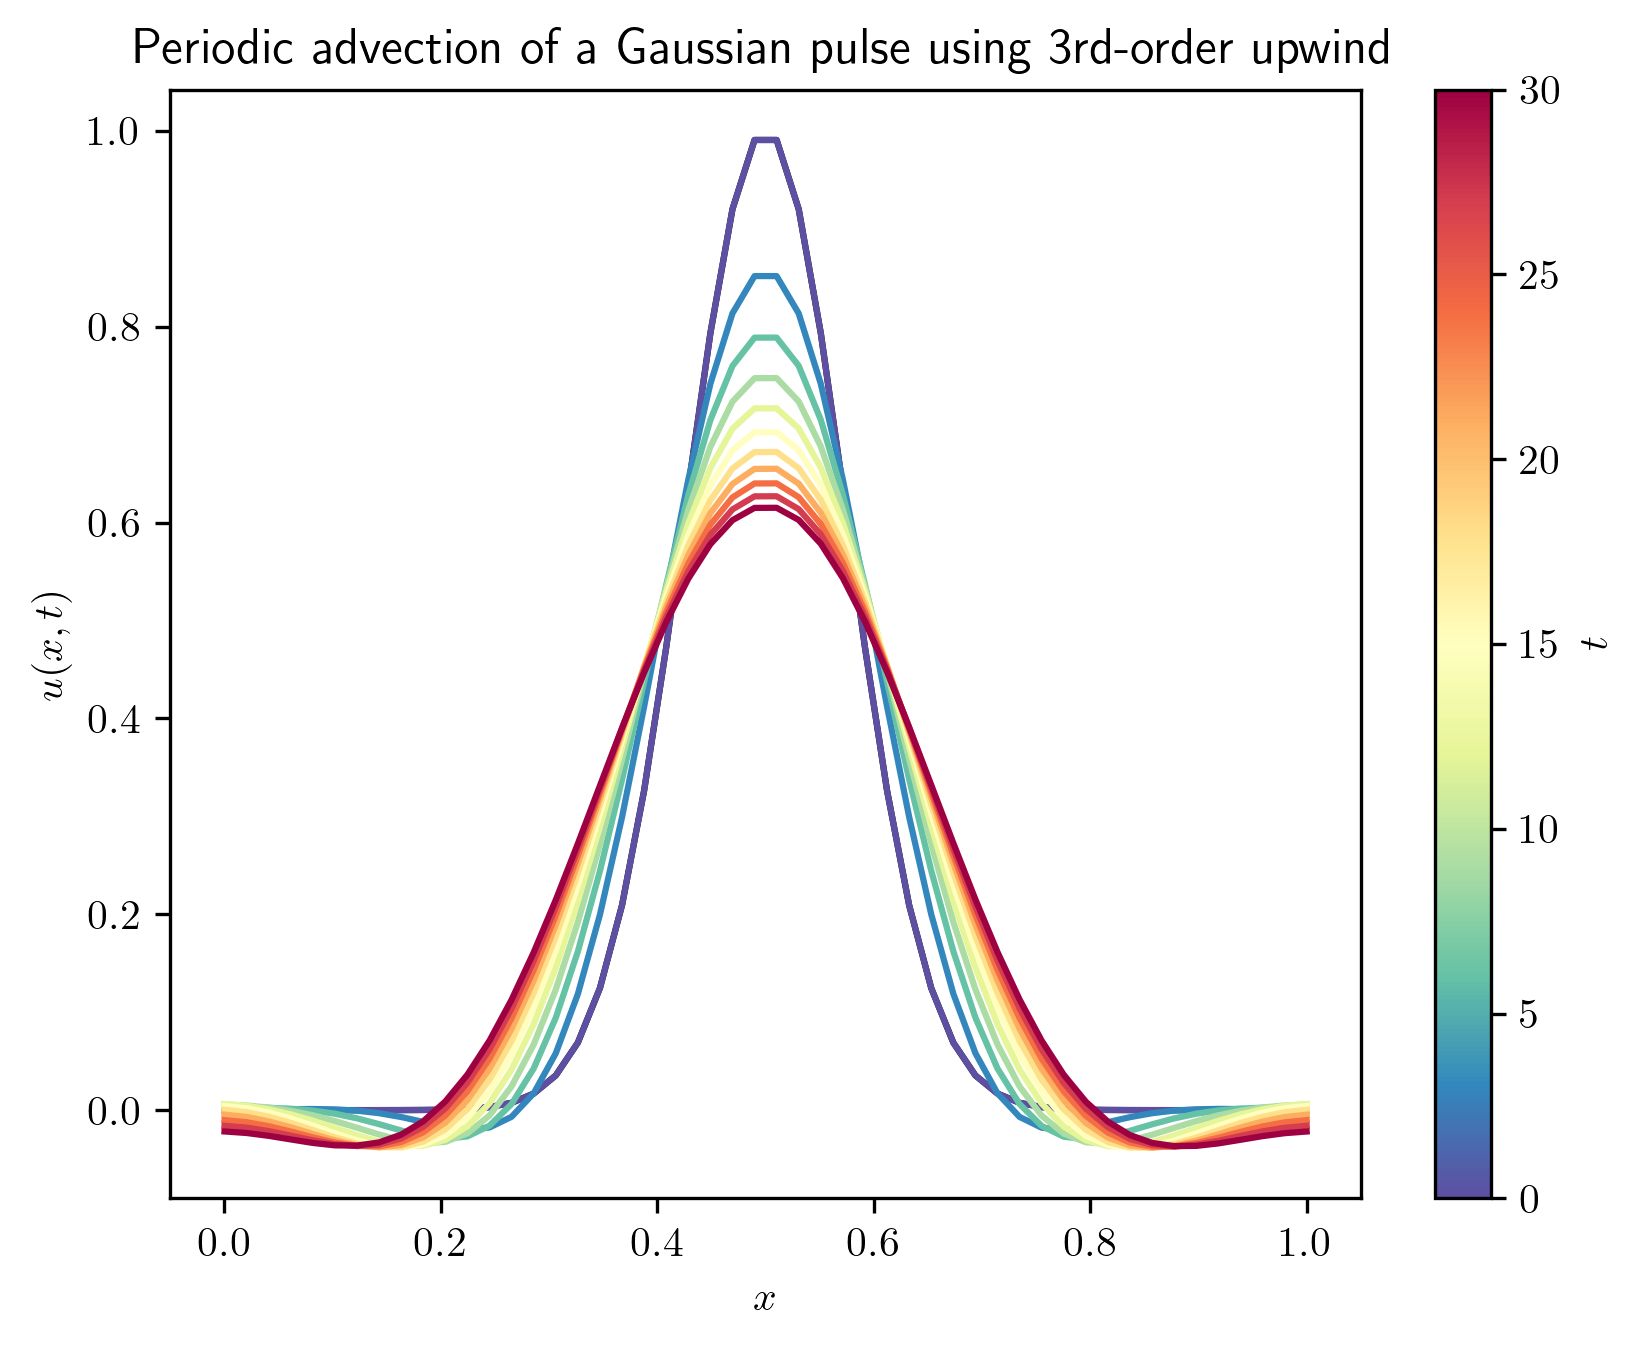

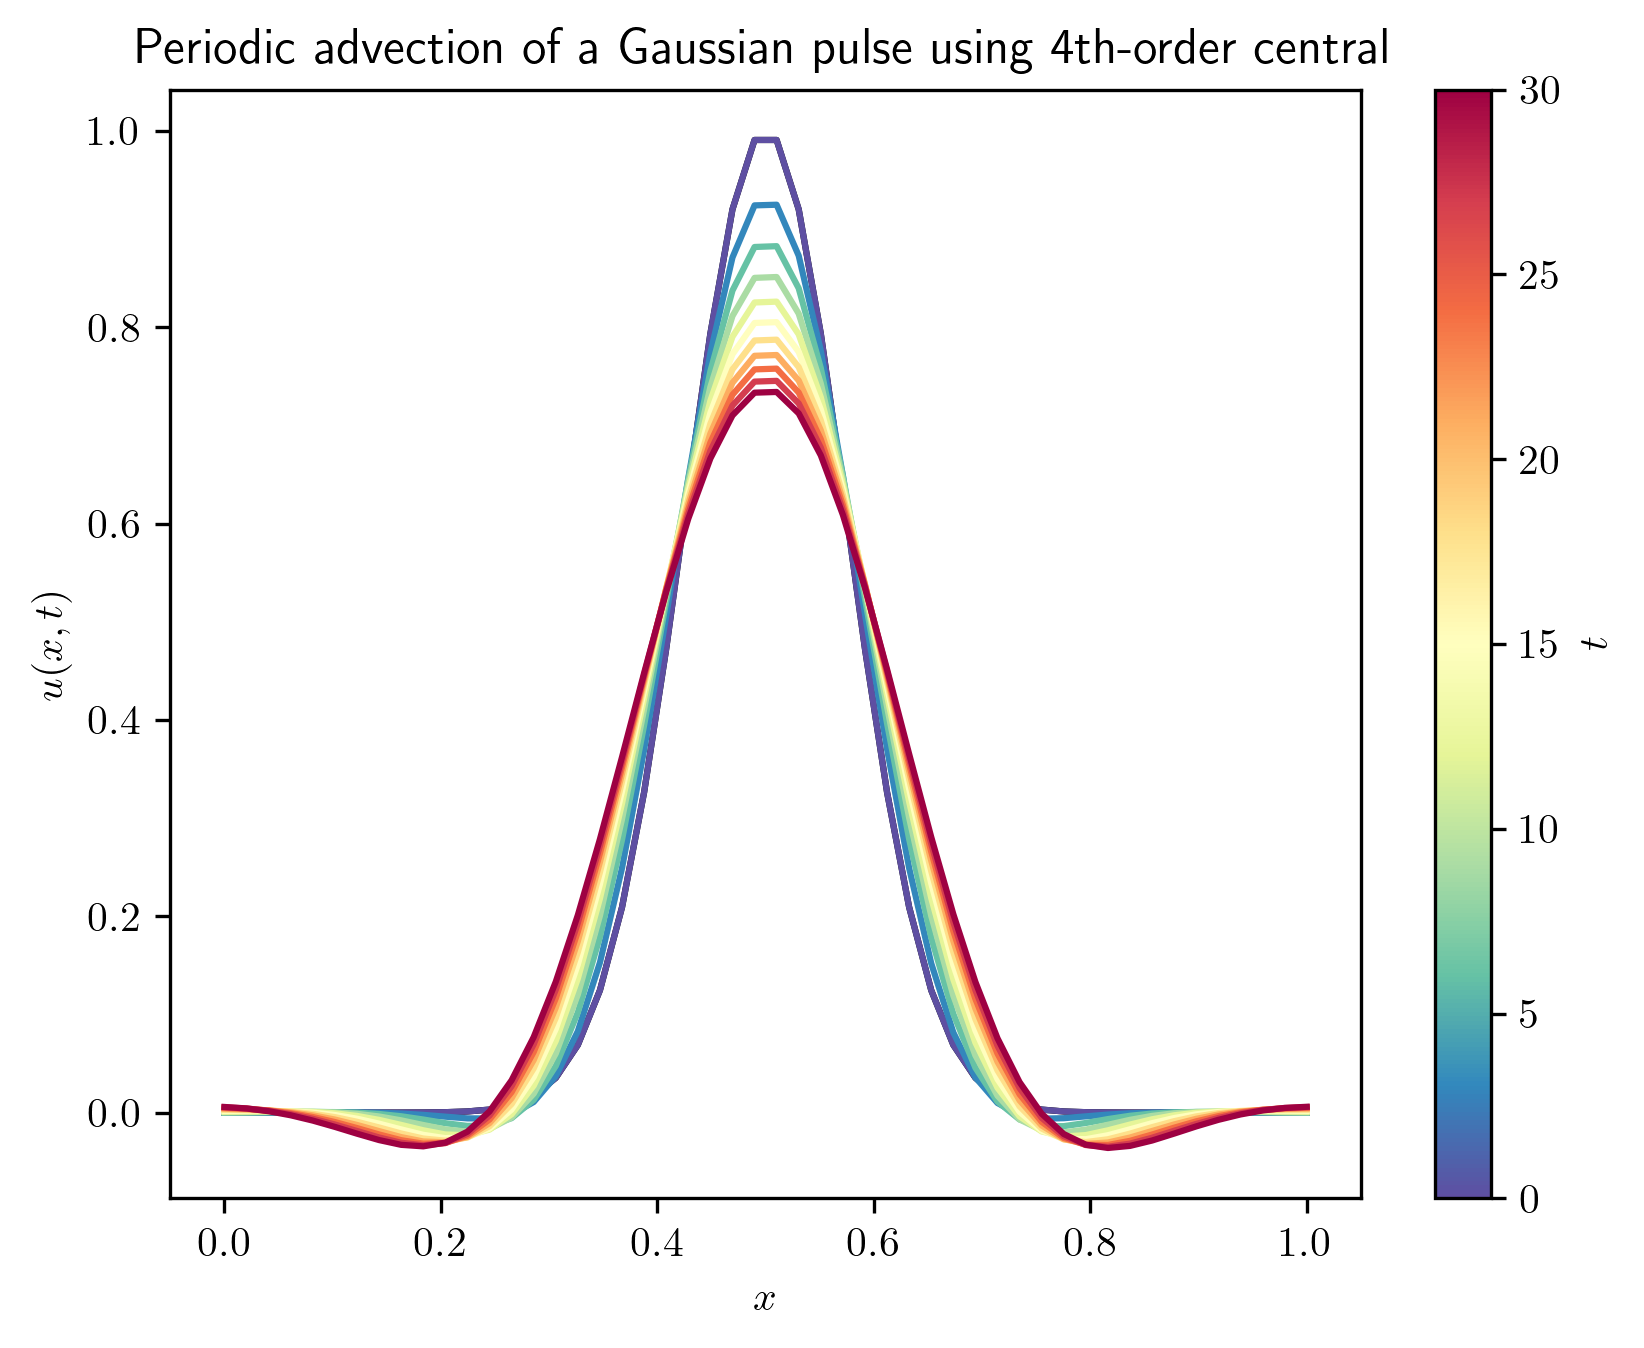

In [132]:
# Plotting the eigenvalue spectra and numerical solutions for each scheme
L = 1; T = 30; Nx = 50; a = 1; CFL = 1
# Initialize solution at t=0
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]
dt = CFL * dx / np.abs(a)
var_t = np.arange(0, T, dt)
Nt = len(var_t)
sigma = 3/40; U0 = np.exp(-(x-0.5)**2/(2*sigma**2))
# Initialize list of schemes that will be tested:
listofschemes = ['1st-order upwind', '2nd-order central', '3rd-order upwind', '4th-order central']

listofschemes = ['1st-order upwind', '2nd-order central', '3rd-order upwind', '4th-order central']
for scheme in listofschemes: 
    # Run solver and plot solution
    t, U, D = Integrator(True, scheme, 'LinearAdv1D',L, T, Nx, Nt, U0, 'RK3')
    fig, ax = plt.subplots(1, 1) 
    ax.plot(x,U0,color='k')
    for j in range(0, Nt, int(Nt / 10)):
        ax.plot(x,U[j],color=plt.cm.Spectral_r(t[j]/T))
        
    plt.title('Periodic advection of a Gaussian pulse using %s' % scheme)
    plt.xlabel(r'$x$');plt.ylabel(r'$u(x,t)$');
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, T), cmap='Spectral_r'),ax=ax, orientation='vertical', label=r'$t$')
    plt.show()

#### 1st Order Upwind
The solution appears to be stable as it maintains the overall shape of the Gaussian profile. There is a visible damping of the pulse amplitude over time, which is typical for first-order upwind schemes due to their inherent numerical dissipation.

#### 2nd Order Central
The plot shows significant oscillations developing behind the peak of the pulse, which is indicative of numerical instability. This behavior is typical for central difference schemes, which do not have any inherent numerical dissipation and can introduce non-physical oscillations (dispersion errors) that grow over time.

#### 3rd Order Upwind
The solution appears to be stable and maintains the shape of the Gaussian profile. The third-order upwind scheme introduces more numerical dissipation than the first-order scheme, but less than the second-order scheme. This balance often helps to stabilize the solution while maintaining accuracy.

#### 4th Order Central
Similar to the second-order central scheme, the fourth-order central scheme is also showing signs of instability with the formation of oscillations. These high-order central schemes are more susceptible to instability because they can propagate higher frequency components that are not physically present in the solution

11

## Provblem 4

In [112]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
from numpy import linalg as LA
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

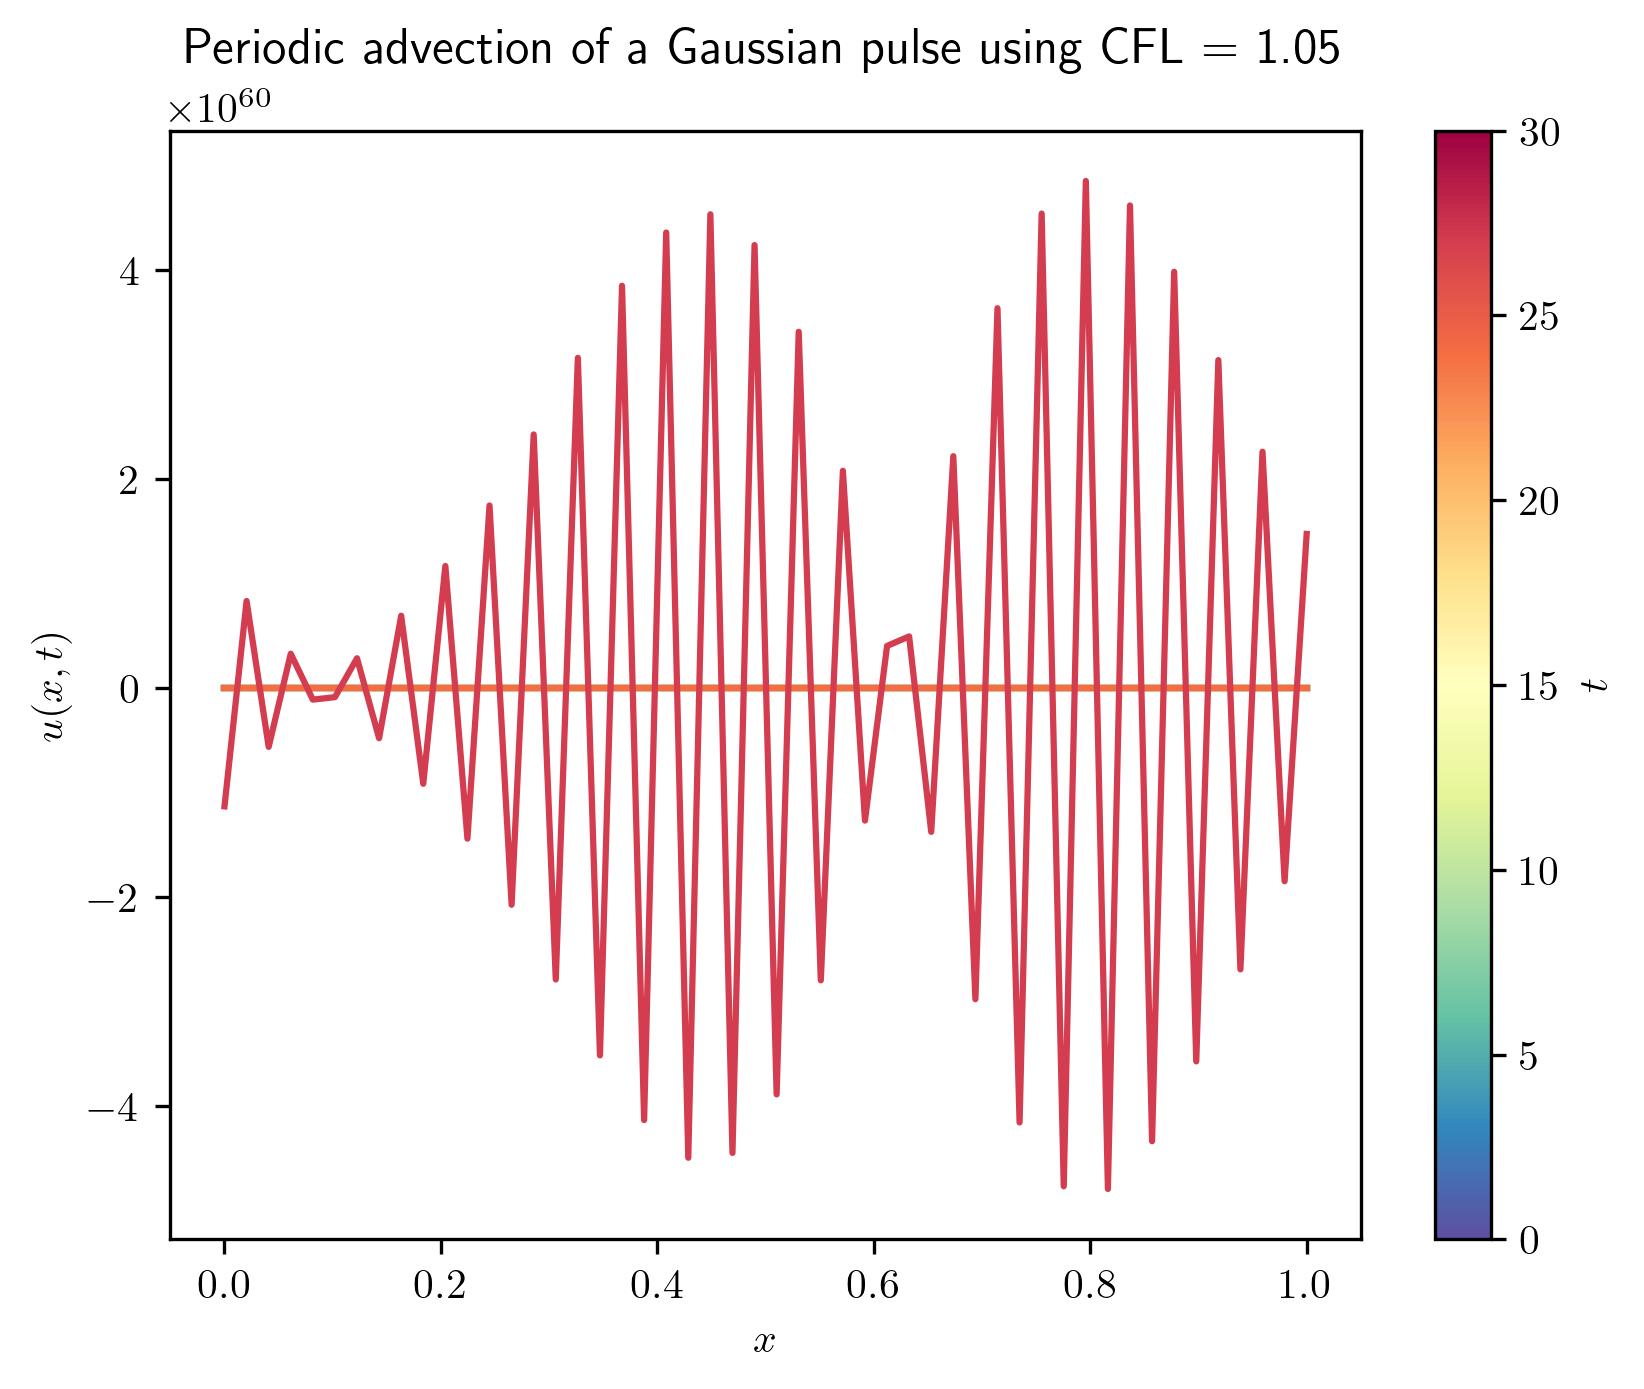

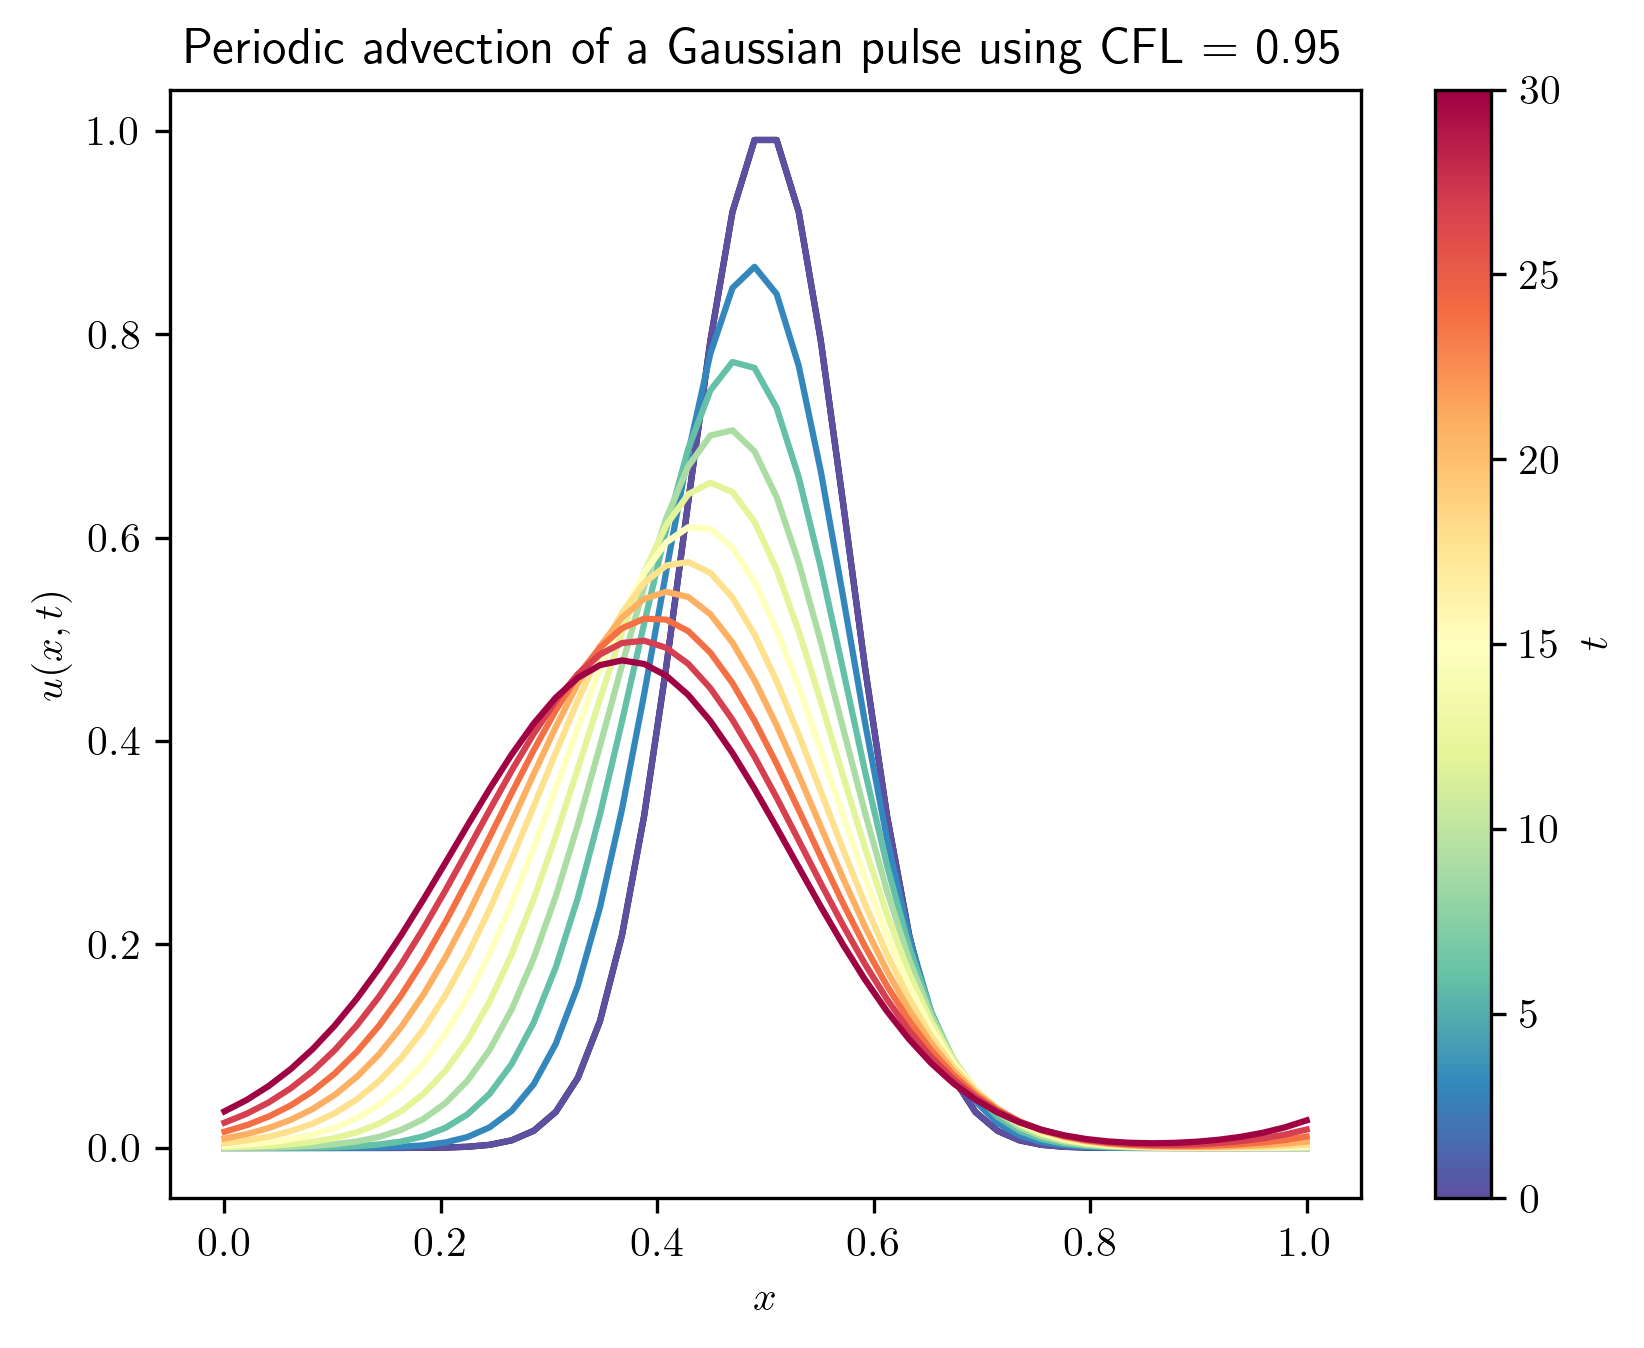

In [118]:
L = 1; T = 30; Nx = 50; a = 1
CFL_m = 1
CFLs = [CFL_m * 1.05, CFL_m * 0.95]

for CFL in CFLs:
    x = np.linspace(0, L, Nx)
    dx = x[1] - x[0]
    dt = CFL * dx / np.abs(a)
    var_t = np.arange(0, T, dt)
    Nt = len(var_t)
    sigma = 3/40; U0 = np.exp(-(x-0.5)**2/(2*sigma**2))
    
    t, U, D = Integrator(True, '1st-order upwind', 'LinearAdv1D',L, T, Nx, Nt, U0, 'Euler')
    A.append(-a*D)
    fig, ax = plt.subplots(1, 1) 
    ax.plot(x,U0,color='k')
    for j in range(0, Nt, int(Nt / 10)):
        ax.plot(x,U[j],color=plt.cm.Spectral_r(t[j]/T))
        
    plt.title('Periodic advection of a Gaussian pulse using CFL = %s' % CFL)
    plt.xlabel(r'$x$');plt.ylabel(r'$u(x,t)$');
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, T), cmap='Spectral_r'),ax=ax, orientation='vertical', label=r'$t$')
    plt.show()

The plot with the supercritial CFL of 1.05 shows a rapidly unstable solution, with the outcome being expected as the CFL condition is violated. This shows that the numerical method is unable to accurately display the behavior of the true solution.

The plot with the CFL of 0.95 is seen to be more stable, with signs of spreading and dissapation, which is typical of the scheme. This is expected as a CFL of 0.95 is within the stability condition.

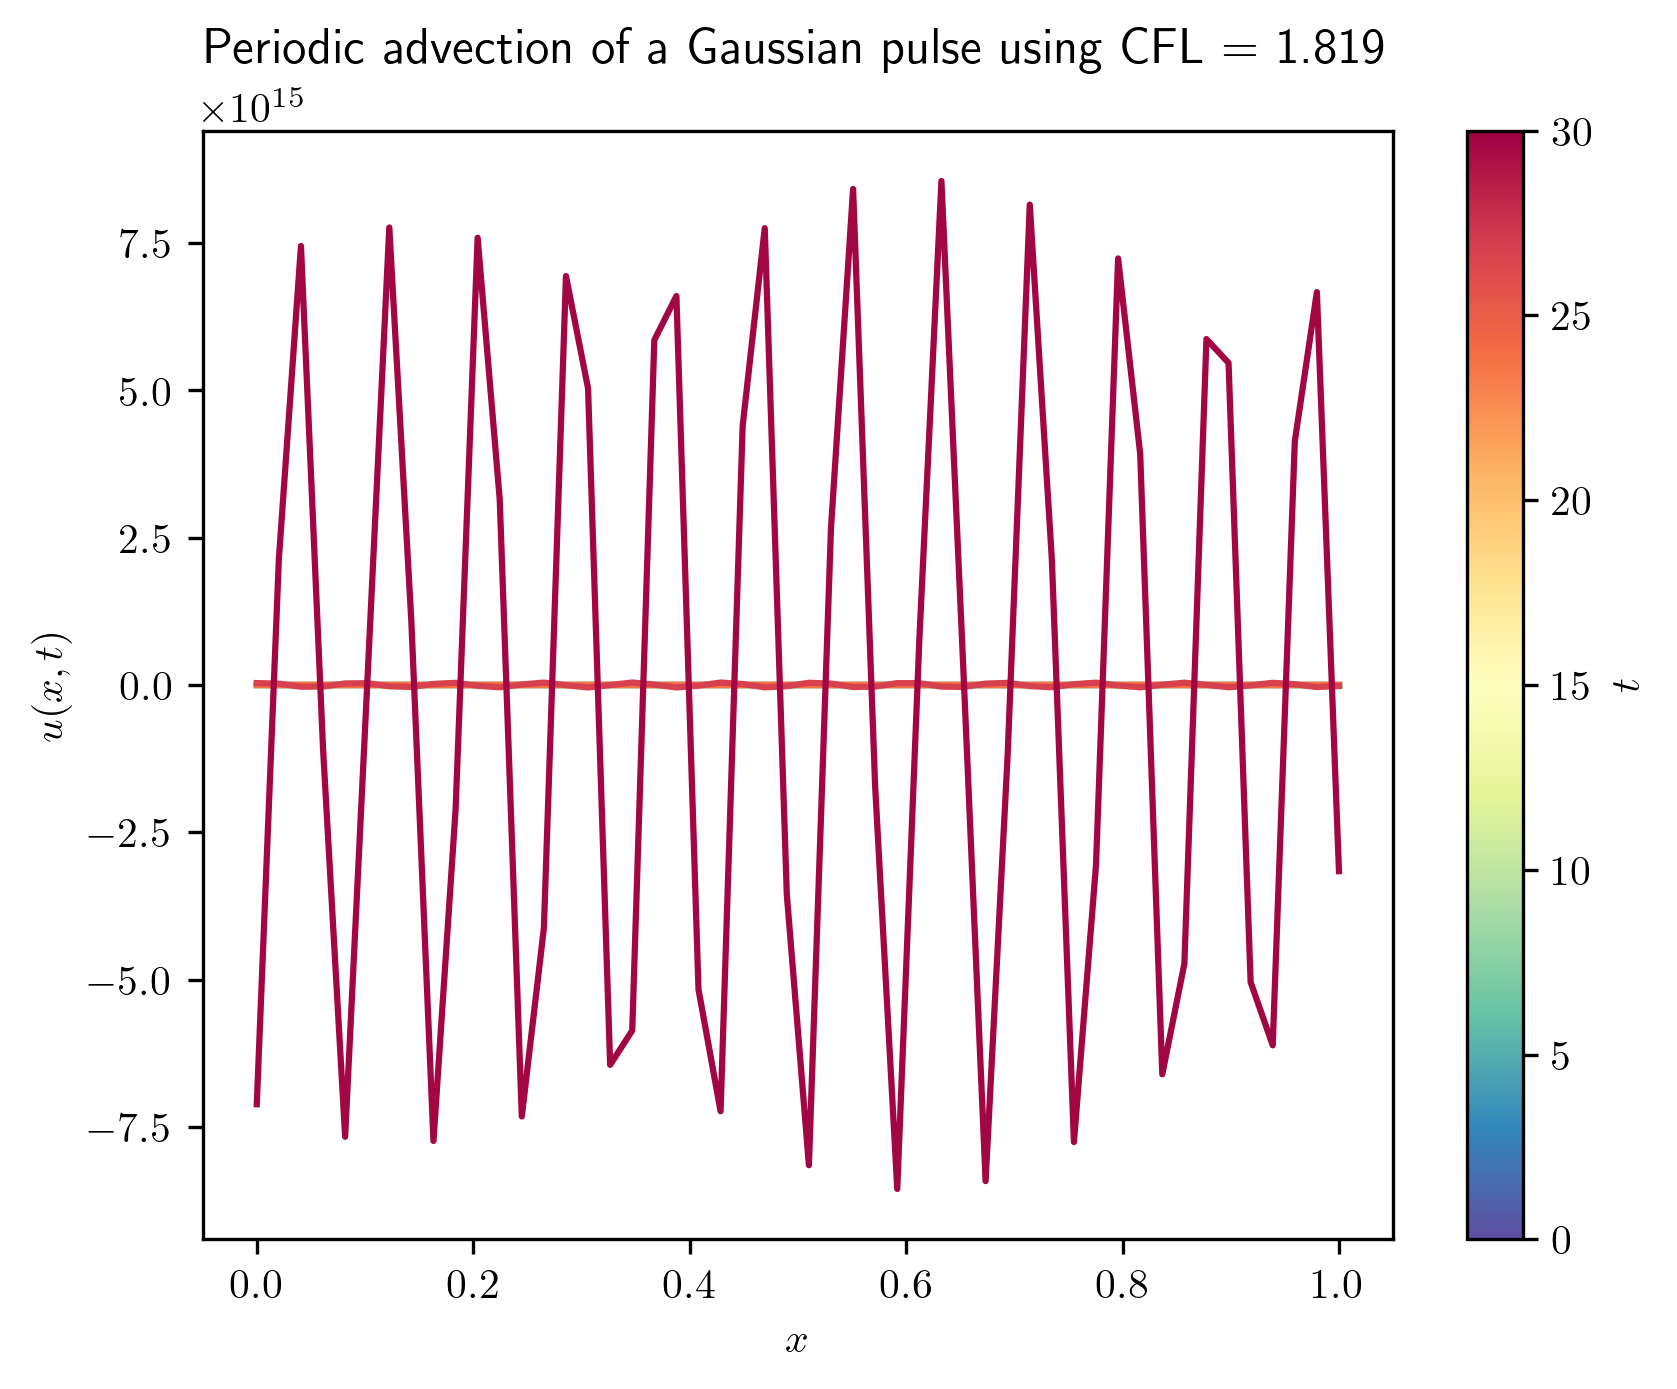

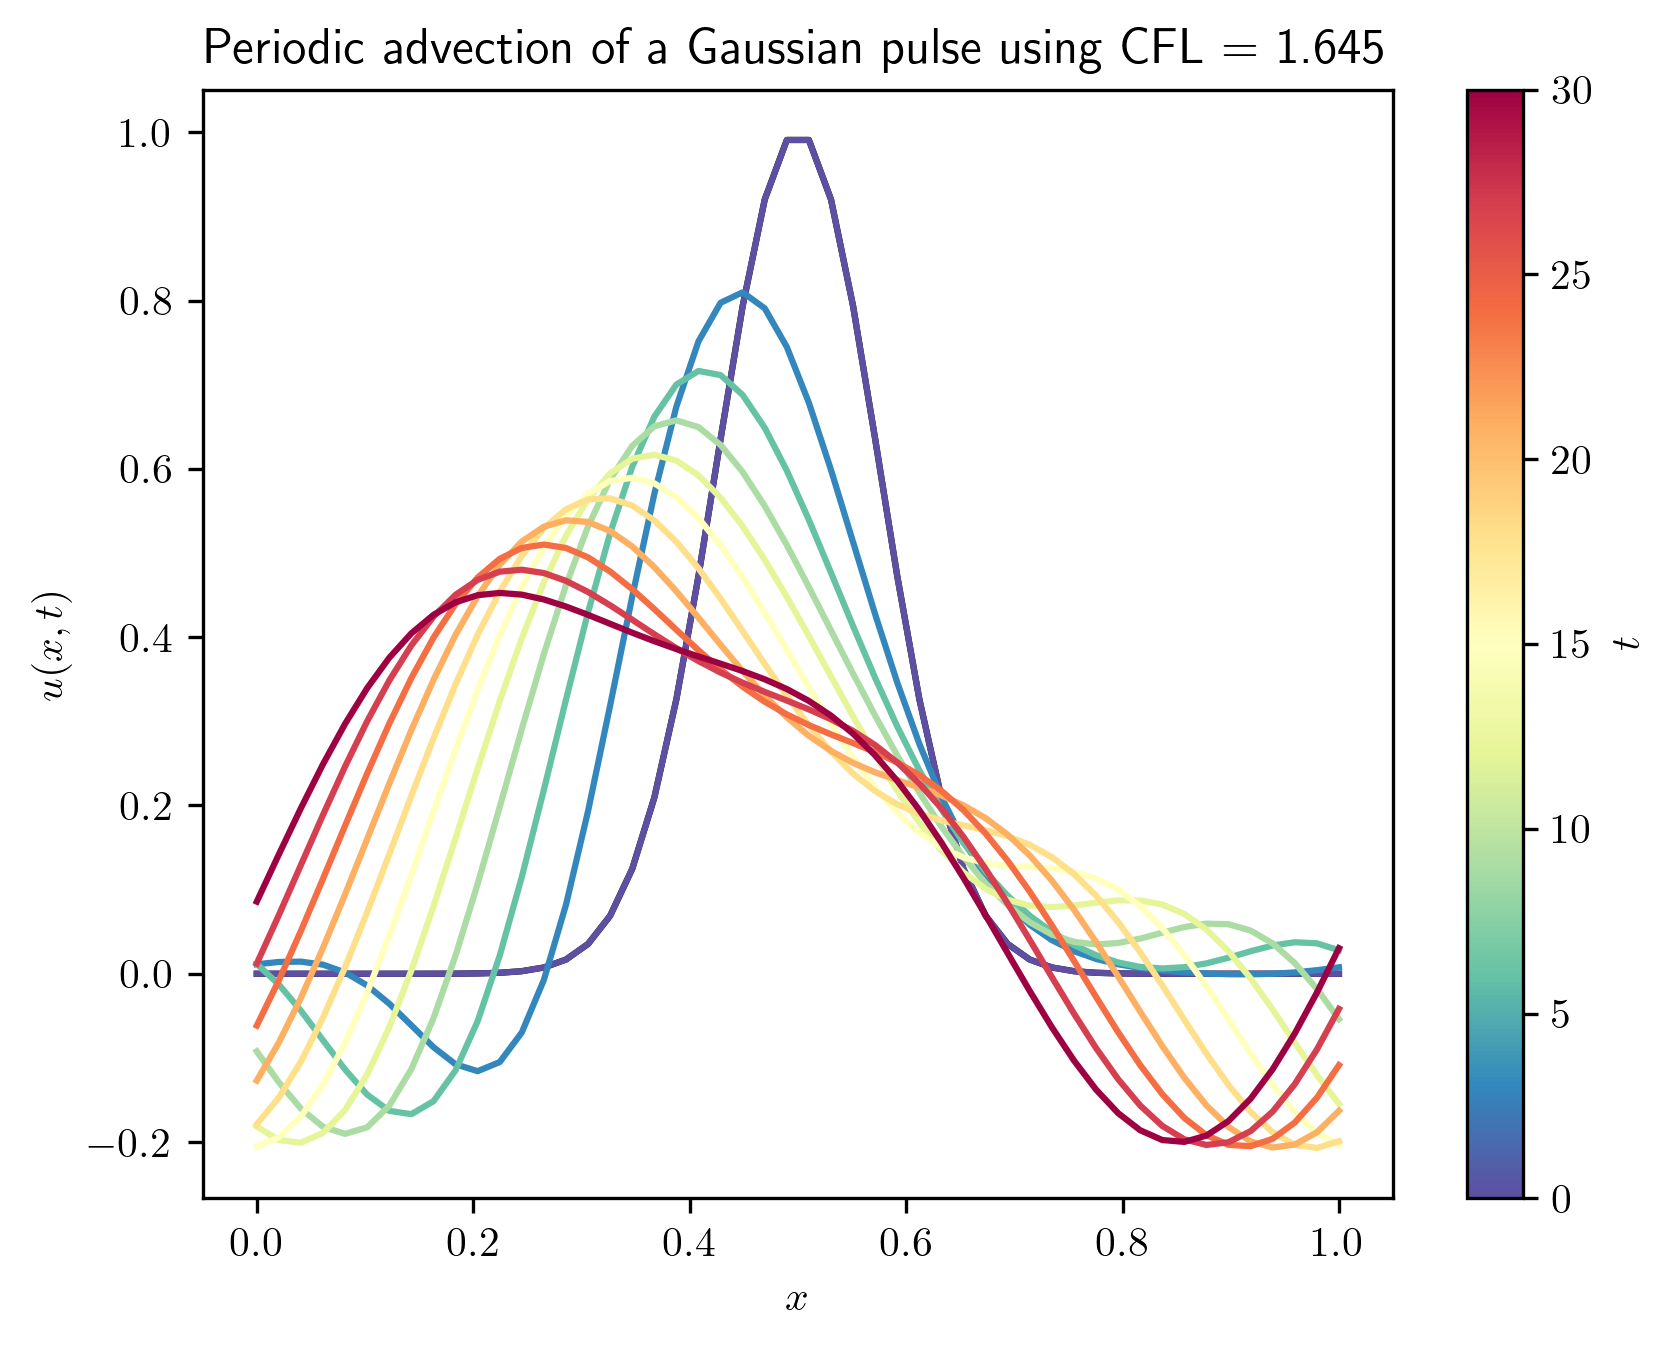

In [124]:
L = 1; T = 30; Nx = 50; a = 1
CFL_m = np.sqrt(3)
CFLs = [CFL_m * 1.05, CFL_m * 0.95]

for CFL in CFLs:
    x = np.linspace(0, L, Nx)
    dx = x[1] - x[0]
    dt = CFL * dx / np.abs(a)
    var_t = np.arange(0, T, dt)
    Nt = len(var_t)
    sigma = 3/40; U0 = np.exp(-(x-0.5)**2/(2*sigma**2))
    
    t, U, D = Integrator(True, '2nd-order central', 'LinearAdv1D',L, T, Nx, Nt, U0, 'RK3')
    A.append(-a*D)
    fig, ax = plt.subplots(1, 1) 
    ax.plot(x,U0,color='k')
    for j in range(0, Nt, int(Nt / 10)):
        ax.plot(x,U[j],color=plt.cm.Spectral_r(t[j]/T))
        
    plt.title('Periodic advection of a Gaussian pulse using CFL = %.3f' % CFL)
    plt.xlabel(r'$x$');plt.ylabel(r'$u(x,t)$');
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, T), cmap='Spectral_r'),ax=ax, orientation='vertical', label=r'$t$')
    plt.show()

In the top plot, there is a rapidly growing solution with significant oscillations. This instability is more pronounced due to the supercritical CFL number, which is expected given that it is outside of the stability condition.

The plot with the CFL of 1.645 is seen to be more stable, with signs of spreading and dissapation, which is typical of the scheme. This is expected as a CFL of 1.645 is within the stability condition.